In [ ]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Modelo SSA

Se procede a realizar el modelo SSA con base en lo que se aprendio en los tutoriales

In [1]:
## Se instalan las librerías requeridas
install.packages("dplyr")
install.packages("Rssa")
library(Rssa)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in install.packages("dplyr"):
“installation of package ‘dplyr’ had non-zero exit status”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘svd’


Loading required package: svd

Loading required package: forecast

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘Rssa’


The following object is masked from ‘package:stats’:

    decompose




In [8]:
library(Rssa)
library(TTR)
library(quantmod)
library(xts)
library(tseries)
#library(TSA)
library(ggplot2)
library(PerformanceAnalytics) ##vamos a ver, rendimientos
library(Metrics)
library(tseries)

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘PerformanceAnalytics’


The following object is masked from ‘package:graphics’:

    legend



Attaching package: ‘Metrics’


The following object is masked from ‘package:forecast’:

    accuracy




#### Funciones Manuales

Se traspasan las funciones manuales creadas con base en la librería Rssa que ayudan en el proceso de SSA

In [2]:
##Hankelización:
UniHankel=function(Y,L){
  k<-length(Y)-L+1
  outer((1:L), (1:k), function(x,y) Y[(x+y-1)])
}

In [3]:
##Función SVD
SVD<- function(Y,L){
  X<-UniHankel(Y,L)
  svd(X)
}

In [4]:
###W-correlation
W.corr<-function(Yt,L, groups){
  m<-length(groups); w.corr<-diag(m)
  N<-length(Yt)
  w<-((N+1)-abs((N+1)/2-L)-abs((N+1)/2-1:N)-
    abs(abs((N+1)/2-L)-abs((N+1)/2-1:N)))/2
wcorr<-function(i,j){
  Y1<-SSA.Rec(Yt,L,groups[[i]])
Approximation
  sum(w*Y1*Y2)/sqrt(sum(w*Y1^2)*sum(w*Y2^2))}
for (i in 1:(m-1)){
  for (j in (i+1):m){
    w.corr[i,j]=w.corr[j,i]=wcorr(i,j)}}
rownames(w.corr)<-colnames(w.corr)<-groups
w.corr
}

In [5]:
###Plotting Images w.corr
Plt.Img<-function(x){
  min<-min(x)
  max<-max(x)
  yLabels<-rownames(x)
  xLabels<-colnames(x)
  if( is.null (xLabels)){
    xLabels <- c(1:ncol(x))
  }
  if (is.null(yLabels)){
    yLabels <- c(1:nrow(x))
  }
  layout(matrix(data=c(1,2), nrow=1, ncol=2),
         widths=c(4,1), heights=c(1,1))
  ColorRamp<-gray( seq(1,0, length=20))
  ColorLevels<-seq(min, max, length=length(ColorRamp))
                  par(mar=c(3,5,2.5,2))
                  image(1:length(xLabels), 1:length(yLabels),
                        t(x), col=colorRamp, xlab="",
                        ylab = "", axes=FALSE, zlim=c(min, max))
                  title(main=c("Image Plot"))
                  axis(BELOW<-1, at=1:length(xLabels),
                       labels=xLabels, cex.axis=0.7)
                  axis(LEFT<-2, at=1:length(yLabels),
                       labels=yLabels, las=HORIZONTAL<-1,
                       cex.axis=0.7)
                  box()
                  par(mar=c(3,2.5, 2.5,2))
                  image(1, ColorLevels,
                        matrix(data=ColorLevels, ncol=length(ColorLevels), nrow=1),
                        col=colorRamp,
                        xlab="", ylab="",
                        xaxt="n")
                  layout(1)
}

In [7]:
##Singular Values graph
Sing.plt<-function(Y,L){
  lambda<-log(SVD(Y,L)$d)
  d<-length(lambda)
  win<-1:d
  plot.new()
  plot.window(xlim=range(win), ylim=range(lambda))
  usr=par("usr")
  rect(usr[1], usr[3], usr[2], usr[4])
  lines(win, lambda, lwd=2)
  points(win, lambda, pch=21, bg="gray")
  axis(1)
  axis(2)
  box()
  title(xlab="Number")

    title(ylab="Log.Singular Values")}

### Carga de datos

Terminado el proceso de preparación previo se procede a cargar los datos de META

In [9]:
options(digits=3)
options(warn=-1)

#Obtención DATOS:
META<-getSymbols("META", from="2016-05-01", to="2018-01-28",auto.assign = FALSE)
META<-na.omit(META)
META<-META[,4]
head(META)
colnames(META)<-c("META")

           META.Close
2016-05-02        119
2016-05-03        117
2016-05-04        118
2016-05-05        118
2016-05-06        119
2016-05-09        119

An xts object on 2016-05-02 / 2018-01-26 containing: 
  Data:    double [439, 1]
  Columns: META
  Index:   Date [439] (TZ: "UTC")
  xts Attributes:
    $ src    : chr "yahoo"
    $ updated: POSIXct[1:1], format: "2024-05-12 05:54:59"


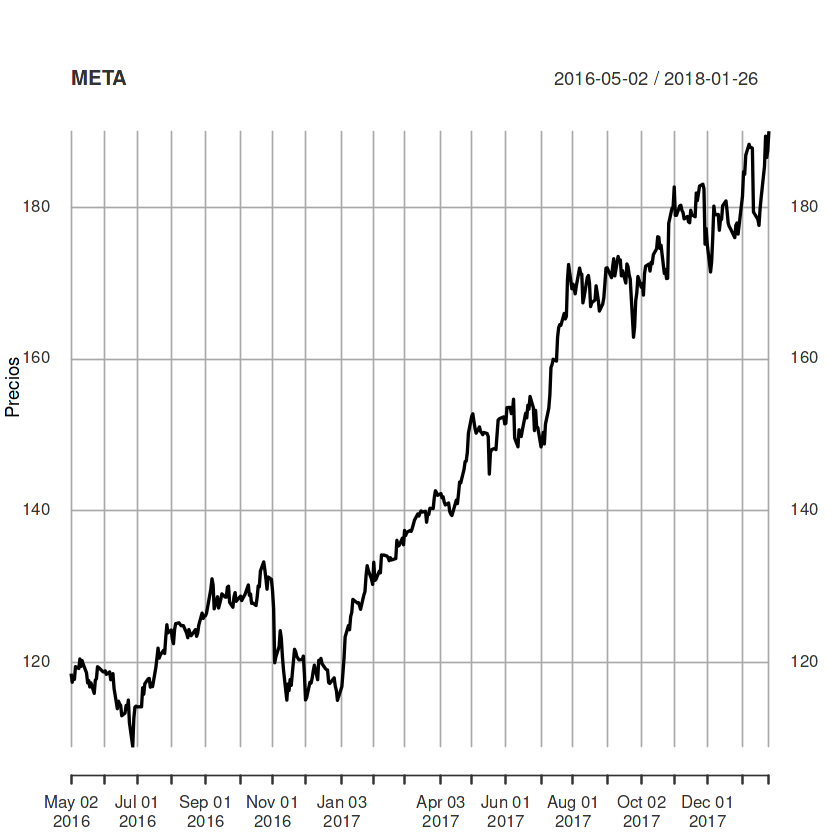

In [10]:
## Se gráfica la serie
### Graficamos la serie
plot(META, ylab="Precios")
str(META)

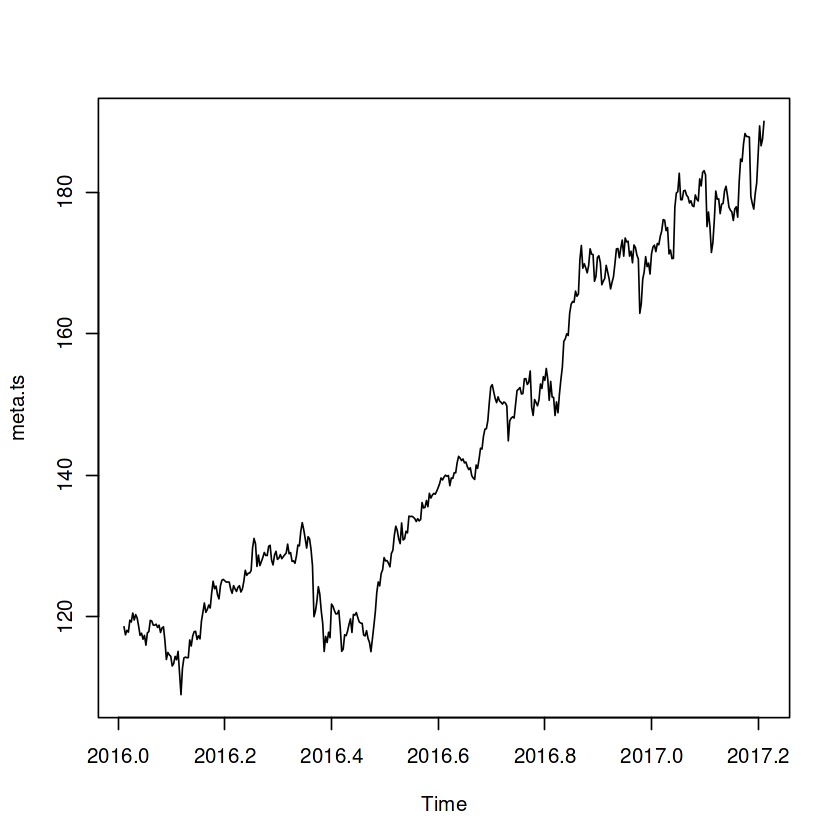

In [11]:
# Se pasan los datos de formato xts a ts, que es el formato que emplea SSA. Se pasa primero a data frame y luego a ts.
META <- data.frame(date=index(META), coredata(META))
META1<-META$META
##pasamos a ts
meta.ts<-ts(META1, start=c(2016,05), frequency = 365)
plot(meta.ts)

### Partición y preprocesamiento de los datos

Con base en lo aprendido en el turorial se procede a partir la información y a realizar el preprocesamiento de los datos

In [12]:
## Preprocesamiento: Partición de datos en conjunto de prueba y de entrenamiento.
## Se parten los datos con el 5% quedando para prueba. 
h <- round(length(meta.ts)*0.05, digits = 0)
h

[1] 22

In [13]:
#Se generan los conjuntos de entrenamiento y prueba
train<-meta.ts[1:(length(meta.ts)-h)]
test<-meta.ts[(length(meta.ts)-h+1):length(meta.ts)]
tail(train)
head(test)
str(test)

train.ts=ts(train,start=c(2016,05), frequency = 365)

[1] 180 181 180 178 177 177

[1] 176 178 178 176 181 185

 num [1:22] 176 178 178 176 181 ...


### Aplicación de la función de SSA

In [14]:
##SSA embeding y separación:
s1<-ssa(train.ts)  #Hay otros métodos como el "topelitz", para series estacionarias. En este caso no aplica.
s1


Call:
ssa(x = train.ts)

Series length: 417,	Window length: 209,	SVD method: eigen
Special triples:  0

Computed:
Eigenvalues: 50,	Eigenvectors: 50,	Factor vectors: 0

Precached: 0 elementary series (0 MiB)

Overall memory consumption (estimate): 0.0864 MiB

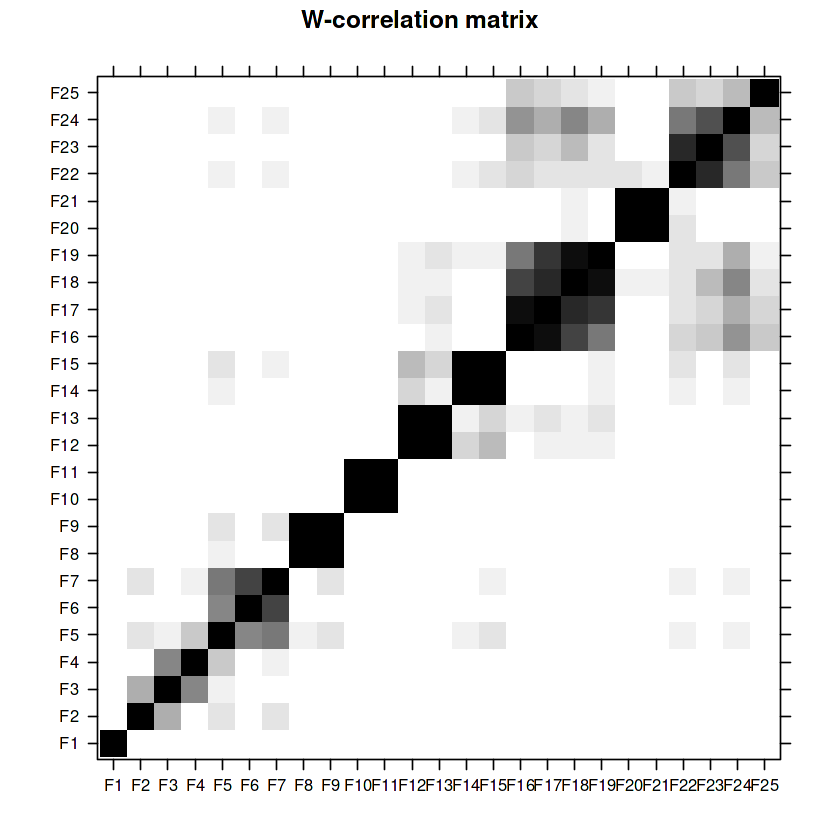

In [15]:
##Se empiezan a usar las herramientas gráficas se empieza con wcor
wplot<-wcor(s1, group=1:25)
plot(wplot)

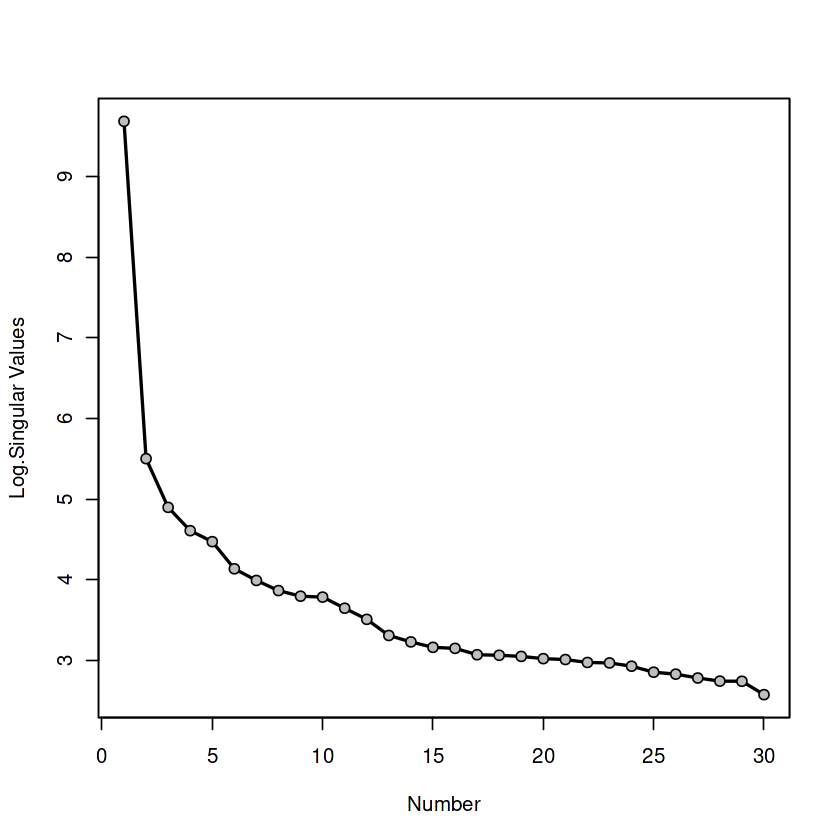

In [17]:
#Se genera la scree-plot.
Sing.plt(meta.ts, 30)

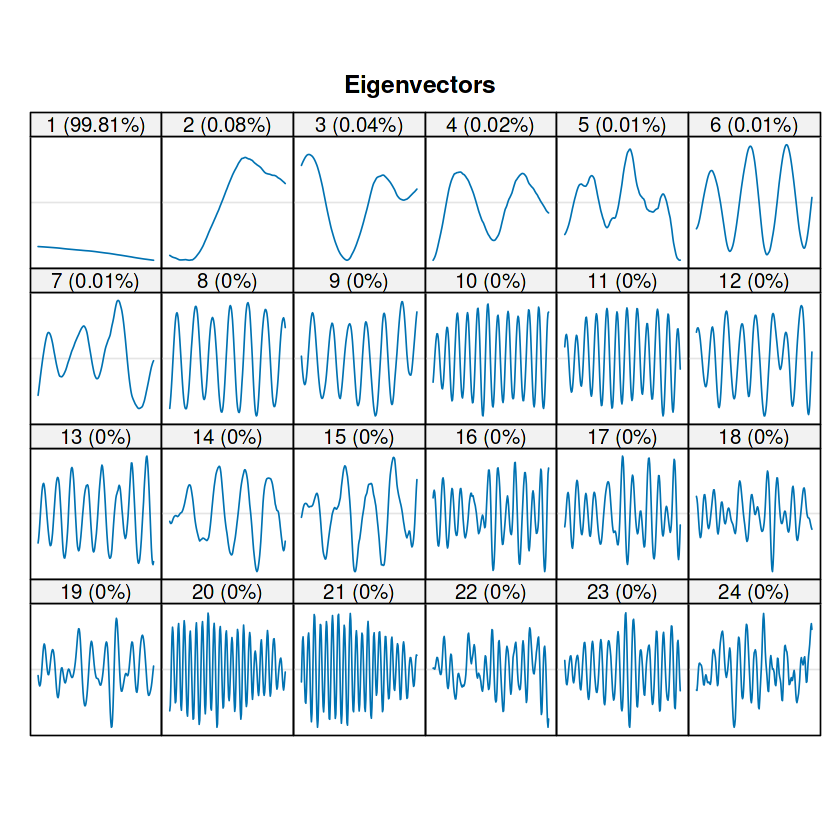

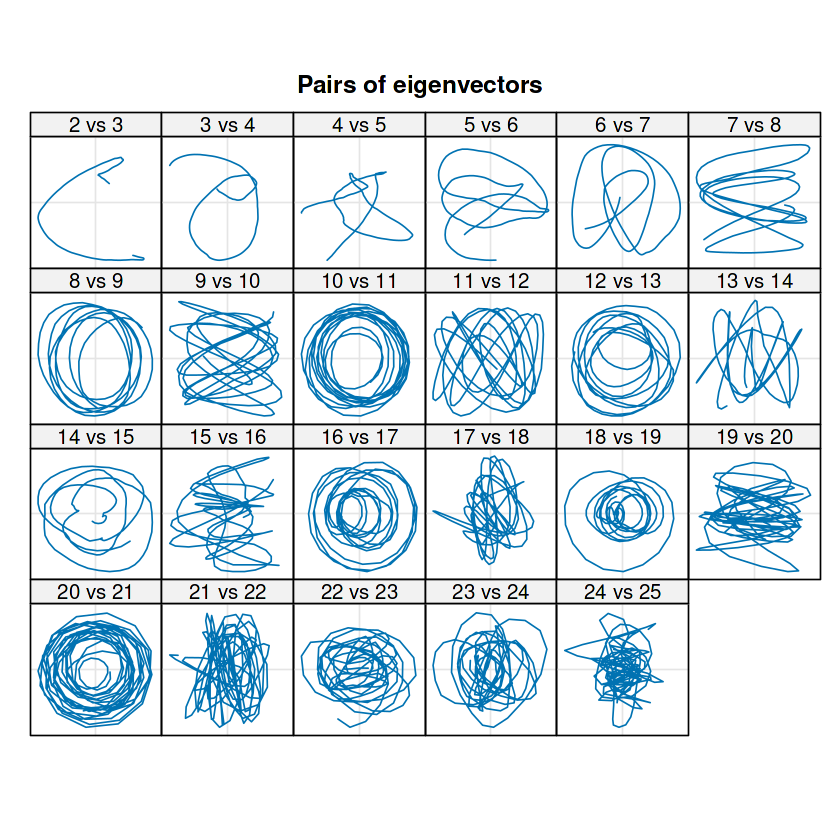

In [18]:
###Gráficas componentes 1D (compoente por componente) y la 2D (pares formen poligonos regulares : estables)
plot(s1, type="vectors", idx=1:24)
plot(s1, type= "paired", idx=2:24, plot.contrib = FALSE)

Con base en lo observado se puede considerar que los vectores 1,2,3,4 y 5 son candidatos de vectores de tendencia. Mientras tanto los vectores 8 y 9, 10 y 11 representan la estacionalidad.

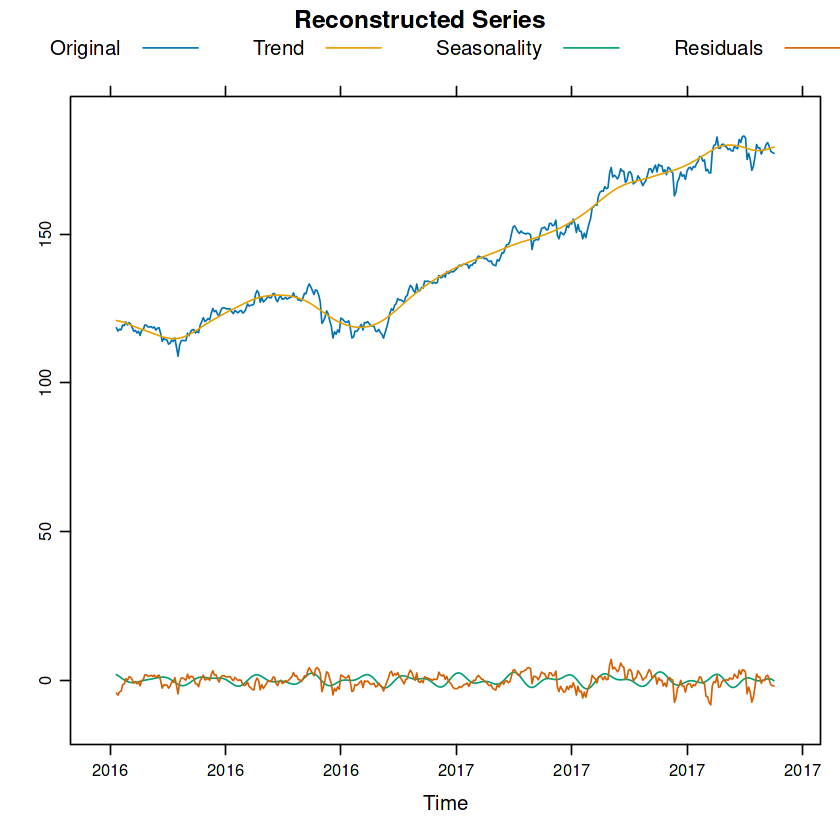

In [20]:
### Se procede a la fase de reconstrucción
r=reconstruct(s1, groups = list(Trend=1:5, Seasonality=c(8:9, 10:11)))
plot(r, add.residuals=TRUE, add.original=TRUE, plot.method="xyplot",
     superpose=TRUE, auto.key=list(columns=4))

In [21]:
#Generamos el pronóstico señalando los tripletes de la reconstrucción.
pronostico1<-forecast(s1, groups = list(c(1:5, 8:9, 10:11)), len=h, method="recurrent", 
                                   interval = "prediction", level=c(0.8, 0.99),only.new=TRUE )

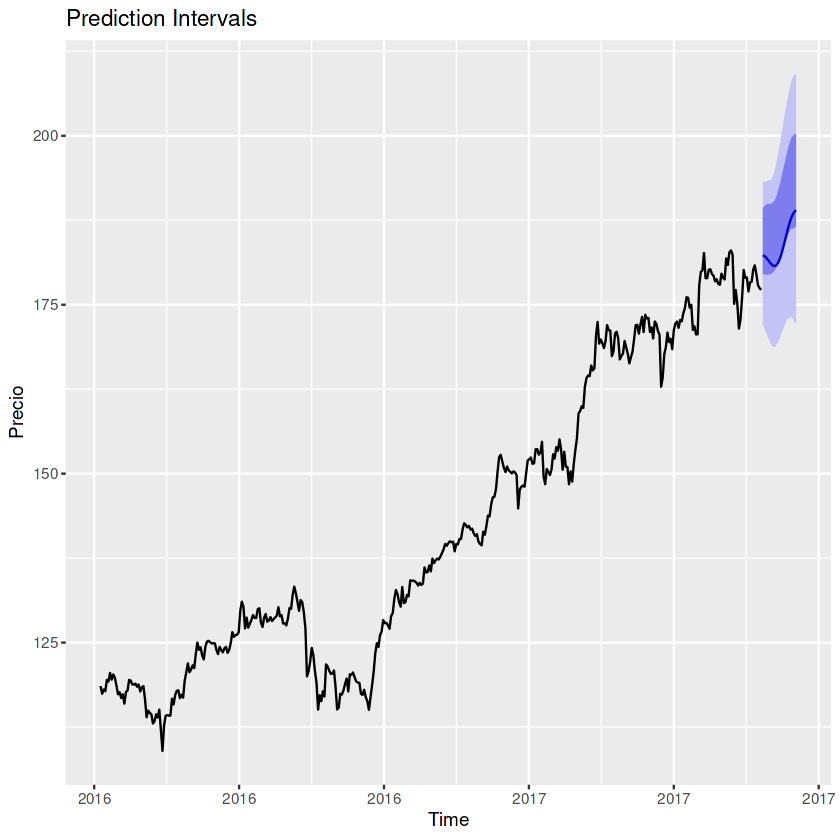

In [22]:
## Se Gráfica
autoplot(pronostico1, type="l", main="Prediction Intervals", ylab="Precio")

In [24]:
pred<-pronostico1$mean
pred

A Time Series:
 [1] 182 182 182 182 181 181 181 181 181 181 181 182 183 184 185 185 186 187 188
[20] 188 189 189

In [26]:
###Cálculo error MAPE, RMSE
library(Metrics)
MSE1<-mse(test,pred)
MSE1
RMSE1<-rmse(test,pred)
RMSE1
MAPE1<-mape(test, pred)
MAPE1

[1] 22.9

[1] 4.78

[1] 0.0233